In [1]:
import os
import sys
sys.path.append('/home/cocoza4/workspace/absorouteio/asr-face-recognition/src')
import yaml
import math
import time
import yaml
import numpy as np
from tqdm.auto import tqdm
import tensorflow as tf
from datetime import datetime
from tensorflow.keras.applications import resnet50, densenet
from PIL import Image
import matplotlib.pyplot as plt

import losses

seed = 1234
np.random.seed(seed)
tf.random.set_seed(seed)

tf.__version__

'2.1.0'

In [8]:
embs = np.array([[1, 2, 3, 4], [1, 2, 3, 4]])

In [17]:
np.linalg.norm(embs, axis=1).mean()

5.477225575051661

In [12]:
np.sqrt(np.square(embs).sum()) / len(embs)

3.872983346207417

In [11]:
xnorm = 0.
for emb in embs:
    xnorm += np.linalg.norm(emb)
    
xnorm / len(embs)

5.477225575051661

In [2]:
shape = [5, 10]
initializer = tf.initializers.he_normal()
tf.Variable(initializer(shape=shape))

<tf.Variable 'Variable:0' shape=(5, 10) dtype=float32, numpy=
array([[ 6.0175818e-01, -5.2796400e-01,  7.4797714e-01,  2.9018996e-02,
         3.4944972e-01,  1.4609915e-01,  1.4374410e+00,  1.2133319e+00,
        -9.2248863e-01, -1.0877663e+00],
       [ 7.2436064e-01, -1.9848469e-01, -4.7809717e-01, -5.7202711e-04,
        -7.9462200e-01,  1.4302993e+00, -4.8167941e-01, -6.3918388e-01,
        -6.8732041e-01,  6.9321853e-01],
       [-2.3826312e-01,  1.0050267e+00,  1.6478889e-01, -1.2355430e+00,
        -6.2056726e-01,  3.2021087e-01, -2.0541719e-01,  7.8044516e-01,
         5.3888565e-01, -1.7732341e-02],
       [ 2.8580654e-01, -6.1302465e-01, -4.4821277e-02,  8.1250571e-02,
         3.4633163e-01,  6.8816590e-01, -9.4399410e-01,  8.3379334e-01,
         2.2618610e-01,  4.0167210e-01],
       [-6.8331742e-01, -1.3142057e-02, -8.2557732e-01, -4.5907727e-01,
         6.1599922e-01, -2.1221493e-01,  9.1125315e-01,  1.1178983e+00,
         3.7770578e-01, -8.4172136e-01]], dtype=float3

In [3]:
initializer = tf.initializers.VarianceScaling()
tf.Variable(initializer(shape=shape))

<tf.Variable 'Variable:0' shape=(5, 10) dtype=float32, numpy=
array([[ 0.58305204,  0.49041533,  0.44654036, -0.15766017, -0.20633309,
        -0.02394199, -0.16620378,  0.26881558,  0.2415042 , -0.37397882],
       [ 0.3381456 , -0.20047382,  0.36472836, -0.12441011, -0.14041537,
         0.34679818, -0.8704428 ,  0.67881286,  0.14886187,  0.02734945],
       [ 0.28471187,  0.8245155 ,  0.6991382 , -0.45852023, -0.2944657 ,
        -0.42089078,  0.04529582, -0.39934322,  0.0411548 , -0.50247395],
       [-0.5189348 ,  0.2958999 ,  0.5307134 ,  0.395918  ,  0.18616596,
         0.02319741, -0.56528765,  0.42270535, -0.25802672, -0.81657857],
       [-0.06711417,  0.50836265, -0.50336486, -0.11514664,  0.3035099 ,
        -0.0704363 ,  0.57697785, -0.02456524,  0.269936  ,  0.93483204]],
      dtype=float32)>

In [4]:
batch_size = 256
lr_steps = [40000, 60000, 80000]
lr_values = [0.004, 0.002, 0.0012, 0.0004]

In [5]:
scale = int(512. / batch_size)
scale

2

In [6]:
optimizer = tf.keras.optimizers.RMSprop()
optimizer.lr

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>

In [7]:
print(optimizer.lr.numpy())

0.001


In [8]:
optimizer.lr.assign(optimizer.lr * 0.5)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=0.0005>

In [9]:
v = tf.constant(np.nan)
v

<tf.Tensor: shape=(), dtype=float32, numpy=nan>

In [11]:
[scale*s for s in lr_steps]


[80000, 120000, 160000]

In [12]:
[v/scale for v in lr_values]

[0.002, 0.001, 0.0006, 0.0002]

In [13]:
global_step = tf.Variable(0, name="global_step", dtype=tf.int64, trainable=False)

In [14]:
lr = tf.compat.v1.train.piecewise_constant(global_step, boundaries=lr_steps, values=lr_values, name='lr_schedule')
lr

functools.partial(<tensorflow.python.keras.optimizer_v2.learning_rate_schedule.PiecewiseConstantDecay object at 0x7f5317c81eb8>, <tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>)

In [15]:
global_step.assign(80001)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=80001>

In [16]:
lr().numpy()

0.0004

In [17]:
ckpt_dir = '/home/cocoza4/models/arcface_models/densenet121'

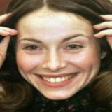

In [18]:
path = '/home/cocoza4/datasets/lfw_mtcnnpy_160/Yekaterina_Guseva/Yekaterina_Guseva_0001.png'
img = Image.open(path).resize((112, 112))
img

In [19]:
np_img = np.asarray(img)

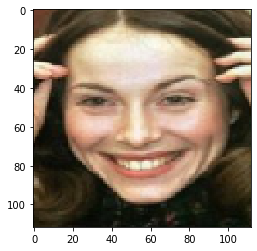

In [20]:
plt.imshow(tf.image.random_flip_left_right(np_img))

In [21]:
img_tensor = tf.constant(np.asarray(img), dtype=tf.float32)
img_tensor.shape

TensorShape([112, 112, 3])

In [22]:
from tensorflow.keras.applications import densenet

In [23]:
img_tensor2 = tf.constant(np.asarray(img), dtype=tf.float32)

In [24]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def imagenet_preprocess(x):
    # image /= 255.
    # image[..., 0] -= mean[0]
    # image[..., 1] -= mean[1]
    # image[..., 2] -= mean[2]
    # image[..., 0] /= std[0]
    # image[..., 1] /= std[1]
    # image[..., 2] /= std[2]
    x /= 255.
    x = tf.stack([x[..., 0] - mean[0], x[..., 1] - mean[1], x[..., 2] - mean[2]], axis=-1)
    x = tf.stack([x[..., 0] / std[0], x[..., 1] / std[1], x[..., 2] / std[2]], axis=-1)
    return x

x1 = imagenet_preprocess(img_tensor)
inputs = x1

In [25]:
x2 = densenet.preprocess_input(img_tensor)

In [26]:
np.isclose(x1, x2, atol=0.001).all()

True

In [27]:
epochs = 2
n_classes = 16
lr = 0.001
m1 = 1.0
m2 = 0.3
m3 = 0.2
s = 64.
img_w = 112
img_h = 112
embedding_size = 512

base_logdir = '/tmp/dir'
data_dir = '/home/cocoza4/datasets/lfw_sample'

In [28]:
initial_learning_rate =lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=2,
    decay_rate=0.96,
    staircase=True)

In [29]:
optimizer = tf.keras.optimizers.Adam()

In [30]:
lr_schedule(10), tf.cast(128, tf.int64)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0008153726>,
 <tf.Tensor: shape=(), dtype=int64, numpy=128>)

In [32]:
class ArcFaceModel(tf.keras.Model):
    
    def __init__(self, backbone, embedding_size):
        super().__init__()
        self.backbone = backbone
        self.bn1 = tf.keras.layers.BatchNormalization()
#         self.dropout = tf.keras.layers.Dropout(0.4)
        self.dense = tf.keras.layers.Dense(embedding_size)
        self.bn2 = tf.keras.layers.BatchNormalization(scale=False)
        
    def call(self, inputs, training=False):
        x = self.backbone(inputs, training=training)
        x = self.bn1(x, training=training)
#         x = self.dropout(x, training=training)
        x = self.dense(x, training=training)
        x = self.bn2(x, training=training)
        return x

In [33]:
# data = data-127.5
# data = data*0.0078125

inputs = (img_tensor - 127.5) * 0.0078125

In [34]:
backbone = tf.keras.applications.DenseNet121(weights=None, include_top=False, pooling='avg')
# backbone = tf.keras.applications.ResNet101(include_top=False, pooling='avg')
model = ArcFaceModel(backbone, embedding_size)
model

In [35]:
backbone(tf.expand_dims(inputs, axis=0))

<tf.Tensor: shape=(1, 1024), dtype=float32, numpy=
array([[0.02434446, 0.00360292, 0.03869193, ..., 0.02997716, 0.00564097,
        0.01988139]], dtype=float32)>

In [36]:
embeddings = model(tf.expand_dims(inputs, axis=0), training=False)
embeddings

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[-1.87613685e-02,  1.60674881e-02, -3.00272442e-02,
         4.15759869e-02, -1.45169348e-02, -5.32594603e-03,
         3.57160307e-02, -3.65322754e-02,  9.82430950e-03,
        -1.78041905e-02,  2.38980614e-02, -3.28363702e-02,
         3.60440128e-02, -6.57016644e-04,  4.43468615e-02,
        -2.30651977e-03, -4.93462272e-02, -2.30298005e-02,
        -8.99814907e-03,  7.89491087e-03,  1.12160780e-02,
         1.04169911e-02,  4.05542813e-02, -3.39755453e-02,
        -3.32789011e-02, -2.66066100e-02,  2.02119746e-03,
        -9.40856989e-03,  2.17544101e-03, -2.73370221e-02,
        -2.45315228e-02,  1.21938633e-02,  2.26359330e-02,
         4.28859740e-02, -1.80550758e-02,  7.92452786e-03,
        -1.87597182e-02, -4.65440676e-02, -8.03090073e-03,
         9.51390993e-03,  2.65928935e-02,  9.16753337e-03,
         3.06984270e-03, -3.25369351e-02, -1.45216640e-02,
        -8.80370475e-03,  2.07088776e-02,  2.47810092e-02,
      

In [37]:
embeddings = tf.stack([tf.ones((1, embedding_size)), tf.ones((1, embedding_size))*2], axis=1)[0]
embeddings

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[1., 1., 1., ..., 1., 1., 1.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)>

In [38]:
norm_embedding = tf.nn.l2_normalize(embeddings, axis=1) * s
# embedding = tf.divide(embeddings, norm_embedding, name='norm_embedding')
norm_embedding

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[2.828427, 2.828427, 2.828427, ..., 2.828427, 2.828427, 2.828427],
       [2.828427, 2.828427, 2.828427, ..., 2.828427, 2.828427, 2.828427]],
      dtype=float32)>

In [39]:
# random_normal = np.random.normal(size=[n_classes, norm_embedding.shape[-1]])
# random_normal.shape

In [44]:
weights = tf.Variable(tf.random.truncated_normal(shape=[n_classes, norm_embedding.shape[-1]]), 
                      name='embedding_weights',
                      dtype=tf.float32)
norm_weights = tf.nn.l2_normalize(weights, axis=1)
norm_weights

<tf.Tensor: shape=(16, 512), dtype=float32, numpy=
array([[ 0.03763539, -0.03190944, -0.00048515, ...,  0.01377497,
        -0.01152797, -0.00066509],
       [ 0.0579932 ,  0.05403734,  0.06520945, ...,  0.06305415,
        -0.09200087, -0.0398398 ],
       [-0.04738777, -0.01313001,  0.07448193, ...,  0.04901741,
         0.05168638,  0.00314881],
       ...,
       [ 0.00599919,  0.01139707,  0.01388642, ...,  0.02630946,
         0.06722885,  0.00757029],
       [-0.00323207, -0.06361695,  0.07606632, ...,  0.03697778,
         0.01401526, -0.04012578],
       [ 0.09497119, -0.08928275,  0.02929522, ..., -0.01689564,
         0.01765853, -0.06013283]], dtype=float32)>

In [45]:
fc7 = tf.matmul(norm_embedding, tf.transpose(norm_weights), name='cos_t')
fc7

<tf.Tensor: shape=(2, 16), dtype=float32, numpy=
array([[-0.64860344,  0.95354474,  0.7308316 ,  2.2078445 ,  1.2869488 ,
        -0.5524014 ,  2.834073  ,  2.217826  ,  4.4459214 , -2.2694304 ,
         1.3520737 , -1.8731047 ,  0.2938025 ,  1.3855834 ,  1.6590507 ,
         2.3819718 ],
       [-0.64860344,  0.95354474,  0.7308316 ,  2.2078445 ,  1.2869488 ,
        -0.5524014 ,  2.834073  ,  2.217826  ,  4.4459214 , -2.2694304 ,
         1.3520737 , -1.8731047 ,  0.2938025 ,  1.3855834 ,  1.6590507 ,
         2.3819718 ]], dtype=float32)>

In [51]:
def arcface_loss(embeddings, weights, labels, n_classes, m1, m2, m3, s):
    norm_embedding = tf.nn.l2_normalize(embeddings, axis=1) * s
    norm_weights = tf.nn.l2_normalize(weights, axis=1)
    fc7 = tf.matmul(norm_embedding, tf.transpose(norm_weights), name='cos_t')
    print('fc7=', fc7)
    indices = tf.stack([tf.range(norm_embedding.shape[0])[:, None], labels[:, None]], axis=-1)
    zy = tf.gather_nd(fc7, indices=indices)
    print('zy=', zy)
    cos_t = zy / s
    theta = tf.acos(cos_t)
    new_zy = (tf.cos(theta*m1 + m2) - m3) * s
    diff = new_zy - zy
    prelogits = fc7 + tf.one_hot(labels, n_classes) * diff
    print('prelogits=', prelogits)
    
    print(tf.nn.softmax_cross_entropy_with_logits(labels[:, None], prelogits))
    print(tf.nn.softmax(tf.nn.softmax_cross_entropy_with_logits(labels[:, None], prelogits)))
    cce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    loss = cce(labels, prelogits)

    return loss

In [53]:
labels = tf.constant([0, 1, 4, 2, 3])

np_embeddings = np.random.normal(size=(len(labels), embedding_size))
np_weights = np.random.normal(size=(n_classes, embedding_size))

embeddings = tf.constant(np_embeddings, dtype=tf.float32)
weights = tf.Variable(np_weights, name='embedding_weights', dtype=tf.float32)

embeddings.shape, weights.shape

(TensorShape([5, 512]), TensorShape([16, 512]))

In [54]:
arcface_loss(embeddings, weights, labels, n_classes, m1, m2, m3, s)

fc7= tf.Tensor(
[[ 3.317935    5.6562977  -3.7508993   1.1437958  -1.8169177   1.6026498
   3.1707225   0.04199874  2.0338802  -1.0047256   0.0183399   3.217183
   3.7887475   1.8762394  -5.2336226   3.1339884 ]
 [-5.0829625  -2.3999958   3.692803    1.1153153  -0.39647946 -0.6492146
  -3.1972399  -0.5114299   2.3976882  -3.0261924   1.7650805  -1.0628681
   0.22858846  1.422221    2.0530803   1.2473377 ]
 [ 3.078256    1.4128855  -4.274635    1.9914747   3.6377141  -3.3860402
  -3.6145387  -3.3598707  -0.2553854  -3.7376404  -0.10067868  0.8508465
   2.3102226  -2.3116798   0.42377177 -2.4772635 ]
 [ 2.748749   -4.396695   -0.3434921   0.21728182  2.8769233  -0.86855507
   1.0436699   1.6044765   3.3574157  -2.038629    2.426749   -4.086615
  -7.881054   -1.6601723  -3.0188694   0.4363377 ]
 [-0.07416464 -5.268386   -3.164917    1.3993866  -0.55918646  0.8092506
   0.296175    1.0570521   2.2183661  -1.1731368   1.6332489   4.802745
  -2.347561    5.2277284  -2.2327604  -1.2765193 ]],

<tf.Tensor: shape=(), dtype=float32, numpy=35.538944>

In [55]:
@tf.function
def train_step(emb_weights, labels, optimizer):
    with tf.GradientTape(persistent=False) as tape:
        loss = losses.arcface_loss(embeddings, emb_weights, labels, n_classes, m1, m2, m3, s)
    
    trainable_vars = model.trainable_variables + [emb_weights]
    gradients = tape.gradient(loss, trainable_vars)
    print(gradients)
    optimizer.apply_gradients(zip(gradients, trainable_vars))

    return loss

In [56]:
weights

<tf.Variable 'embedding_weights:0' shape=(16, 512) dtype=float32, numpy=
array([[-0.5148968 , -0.11779637, -0.10890643, ...,  0.21476126,
         1.4193898 , -0.53445953],
       [ 0.7982284 , -0.663361  ,  0.23064607, ..., -1.0103339 ,
         0.7351496 , -0.9460761 ],
       [ 1.4648852 , -1.668878  , -1.4180281 , ...,  1.7570642 ,
        -1.3622361 , -1.5086669 ],
       ...,
       [ 0.5511457 , -1.2135758 , -1.2064283 , ...,  0.84455967,
         0.75530773, -2.86367   ],
       [ 0.13893501, -0.60709167,  0.7009326 , ..., -1.3994805 ,
        -0.45315573,  1.5696242 ],
       [ 0.7524545 ,  0.8833188 , -0.8442362 , ...,  1.7759172 ,
         0.23307842, -0.7304884 ]], dtype=float32)>

In [57]:
np_weights.shape

(16, 512)

In [58]:
test_np_weights = np.random.normal(size=(embedding_size, n_classes))


test_weights = tf.Variable(test_np_weights, name='embedding_weights', dtype=tf.float32)

test_weights.shape

TensorShape([512, 16])

In [60]:
test_norm_weights = tf.nn.l2_normalize(test_weights, axis=-1)
test_norm_weights

<tf.Tensor: shape=(512, 16), dtype=float32, numpy=
array([[-0.30044496,  0.31257108, -0.35963044, ..., -0.44853535,
         0.20374057, -0.08821847],
       [-0.45993537, -0.16263159,  0.33934218, ..., -0.03753053,
        -0.29288992, -0.11112409],
       [-0.06098167, -0.12620497,  0.53956735, ...,  0.10737266,
        -0.1870294 , -0.13279285],
       ...,
       [ 0.21551035, -0.67406195,  0.03756414, ..., -0.16988708,
         0.0820425 ,  0.09167027],
       [ 0.08864576, -0.12043781,  0.44998494, ..., -0.00952668,
        -0.00852236,  0.11845292],
       [ 0.14306071, -0.60816026,  0.14002529, ..., -0.32237527,
         0.4930142 , -0.25147077]], dtype=float32)>

# mxnet debug

In [62]:
import mxnet as mx
from mxnet import nd

In [63]:
def mx_execute(symbol, tensors):
    shapes = {n: t.shape for n, t in tensors.items()}
    executor = symbol.simple_bind(ctx=mx.cpu(), **shapes)
    return executor.forward(**tensors)

In [64]:
mx_embeddings = nd.from_numpy(np_embeddings)
mx_embeddings.asnumpy().shape

(5, 512)

In [65]:
mx_embeddings


[[ 0.47143516 -1.19097569  1.43270697 ... -0.03065886 -0.20017185
  -0.48131024]
 [ 1.711426    1.43538709 -1.16752033 ... -0.37743754  0.02675793
  -0.92223825]
 [-1.41675745  0.86352801 -0.20440578 ... -0.73736333 -0.58902251
   0.45794716]
 [ 0.00527183 -0.12097995 -0.35335458 ...  0.74608873  0.1797728
  -0.91737328]
 [ 0.25610753  0.08478901 -0.38450614 ...  0.2732479  -0.13855638
   0.88190423]]
<NDArray 5x512 @cpu(0)>

In [66]:
sym_embeddings = mx.sym.Variable('embedding')
sym_norm_embedding = mx.symbol.L2Normalization(sym_embeddings, mode='instance', name='fc1n')*s
sym_norm_embedding

<Symbol _mulscalar0>

In [67]:
mx_execute(sym_norm_embedding, tensors={'embedding': mx_embeddings.asnumpy()})

[
 [[ 1.3969326  -3.5290382   4.245324   ... -0.09084678 -0.593139
   -1.426194  ]
  [ 4.8684416   4.0832024  -3.3212094  ... -1.073685    0.07611746
   -2.6234632 ]
  [-4.005401    2.4413326  -0.577888   ... -2.0846448  -1.6652614
    1.2946903 ]
  [ 0.01520733 -0.34898373 -1.0193012  ...  2.1521983   0.5185801
   -2.646293  ]
  [ 0.7288586   0.24130175 -1.0942693  ...  0.7776385  -0.39431876
    2.5098186 ]]
 <NDArray 5x512 @cpu(0)>]

In [68]:
sym_weights = mx.sym.Variable(name='weights')
sym_norm_weights = mx.symbol.L2Normalization(sym_weights, mode='instance')
sym_norm_weights

<Symbol l2normalization0>

In [69]:
np_weights

array([[-0.51489683, -0.11779637, -0.10890643, ...,  0.21476126,
         1.41938989, -0.53445953],
       [ 0.79822837, -0.66336103,  0.23064607, ..., -1.01033394,
         0.73514963, -0.9460761 ],
       [ 1.46488528, -1.66887799, -1.41802811, ...,  1.75706428,
        -1.36223613, -1.50866686],
       ...,
       [ 0.55114568, -1.2135758 , -1.2064283 , ...,  0.84455966,
         0.75530775, -2.8636701 ],
       [ 0.13893501, -0.60709167,  0.7009326 , ..., -1.39948041,
        -0.45315574,  1.56962416],
       [ 0.75245452,  0.88331877, -0.84423619, ...,  1.77591714,
         0.23307842, -0.7304884 ]])

In [70]:
tensors = {'weights': np_weights}
mx_execute(sym_norm_weights, tensors)

[
 [[-0.02303948 -0.0052709  -0.00487311 ...  0.00960967  0.06351177
   -0.02391483]
  [ 0.03576792 -0.02972463  0.01033505 ... -0.04527218  0.03294141
   -0.04239285]
  [ 0.06541178 -0.0745207  -0.06331945 ...  0.0784585  -0.06082817
   -0.06736676]
  ...
  [ 0.02454044 -0.05403595 -0.0537177  ...  0.03760505  0.033631
   -0.12750842]
  [ 0.00622409 -0.02719685  0.0314008  ... -0.06269476 -0.02030074
    0.07031696]
  [ 0.0333269   0.039123   -0.03739199 ...  0.078657    0.01032326
   -0.032354  ]]
 <NDArray 16x512 @cpu(0)>]

In [71]:
fc7 = mx.sym.FullyConnected(data=sym_norm_embedding, weight=sym_norm_weights, no_bias=True, 
                            num_hidden=n_classes, name='fc7')
fc7

<Symbol fc7>

In [72]:
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights}
mx_execute(fc7, tensors)

[
 [[ 3.317935    5.656298   -3.7509007   1.143796   -1.8169179   1.6026497
    3.1707242   0.04199889  2.0338802  -1.0047256   0.0183395   3.2171843
    3.7887456   1.8762394  -5.2336216   3.1339884 ]
  [-5.0829635  -2.399995    3.6928043   1.1153157  -0.39647973 -0.6492145
   -3.1972394  -0.5114299   2.397688   -3.026194    1.7650807  -1.0628684
    0.22858942  1.4222214   2.0530798   1.2473373 ]
  [ 3.0782533   1.4128864  -4.2746344   1.9914744   3.6377113  -3.3860378
   -3.6145384  -3.3598695  -0.25538516 -3.7376392  -0.10068059  0.8508477
    2.3102217  -2.3116806   0.42377272 -2.4772625 ]
  [ 2.7487488  -4.3966975  -0.34349293  0.21728253  2.8769236  -0.8685564
    1.043671    1.6044776   3.3574169  -2.03863     2.4267488  -4.0866175
   -7.881054   -1.6601735  -3.0188706   0.43633783]
  [-0.07416447 -5.2683864  -3.164918    1.3993866  -0.55918664  0.8092506
    0.29617345  1.0570514   2.2183666  -1.1731374   1.6332475   4.8027444
   -2.3475597   5.2277293  -2.2327604  -1.2765195 

In [74]:
gt_label = mx.symbol.Variable('softmax_label')
zy = mx.sym.pick(fc7, gt_label, axis=1)
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights, 'softmax_label': labels.numpy()}
mx_execute(zy, tensors)

[
 [ 3.317935   -2.399995    3.6377113  -0.34349293  1.3993866 ]
 <NDArray 5 @cpu(0)>]

In [75]:
gt_label = mx.symbol.Variable('softmax_label')
zy = mx.sym.pick(fc7, gt_label, axis=1)
cos_t = zy/s
t = mx.sym.arccos(cos_t)
t = t*m1 + m2
body = mx.sym.cos(t) - m3
new_zy = body*s
diff = new_zy - zy
diff = mx.sym.expand_dims(diff, 1)
gt_one_hot = mx.sym.one_hot(gt_label, depth = n_classes, on_value=1.0, off_value=0.0)
body = mx.sym.broadcast_mul(gt_one_hot, diff)
fc7 = fc7+body
fc7

<Symbol _plus0>

In [76]:
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights, 'softmax_label': labels.numpy()}
mx_execute(zy, tensors)

[
 [ 3.317935   -2.399995    3.6377113  -0.34349293  1.3993866 ]
 <NDArray 5 @cpu(0)>]

In [77]:
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights, 'softmax_label': labels.numpy()}
mx_execute(fc7, tensors)

[
 [[-2.8518120e+01  5.6562982e+00 -3.7509007e+00  1.1437960e+00
   -1.8169179e+00  1.6026497e+00  3.1707242e+00  4.1998893e-02
    2.0338802e+00 -1.0047256e+00  1.8339500e-02  3.2171843e+00
    3.7887456e+00  1.8762394e+00 -5.2336216e+00  3.1339884e+00]
  [-5.0829635e+00 -3.3992802e+01  3.6928043e+00  1.1153157e+00
   -3.9647973e-01 -6.4921451e-01 -3.1972394e+00 -5.1142991e-01
    2.3976879e+00 -3.0261941e+00  1.7650807e+00 -1.0628684e+00
    2.2858942e-01  1.4222214e+00  2.0530798e+00  1.2473373e+00]
  [ 3.0782533e+00  1.4128864e+00 -4.2746344e+00  1.9914744e+00
   -2.8207481e+01 -3.3860378e+00 -3.6145384e+00 -3.3598695e+00
   -2.5538516e-01 -3.7376392e+00 -1.0068059e-01  8.5084772e-01
    2.3102217e+00 -2.3116806e+00  4.2377272e-01 -2.4772625e+00]
  [ 2.7487488e+00 -4.3966975e+00 -3.2041176e+01  2.1728253e-01
    2.8769236e+00 -8.6855638e-01  1.0436710e+00  1.6044776e+00
    3.3574169e+00 -2.0386300e+00  2.4267488e+00 -4.0866175e+00
   -7.8810539e+00 -1.6601735e+00 -3.0188706e+00  4

In [78]:
softmax = mx.symbol.SoftmaxOutput(data=fc7, label = gt_label, name='softmax', normalization='valid')

In [79]:
tensors = {'embedding': mx_embeddings.asnumpy(), 'weights': np_weights}
mx_execute(softmax, tensors)

[
 [[9.64667930e-16 6.70099974e-01 5.50357690e-05 7.35164946e-03
   3.80682672e-04 1.16322152e-02 5.58044128e-02 2.44275760e-03
   1.79037284e-02 8.57617822e-04 2.38564215e-03 5.84582649e-02
   1.03531338e-01 1.52925849e-02 1.24941798e-05 5.37915900e-02]
  [1.76303704e-18 1.14769523e-03 5.08037329e-01 3.85928228e-02
   8.51024687e-03 6.60968386e-03 5.17115637e-04 7.58612435e-03
   1.39134139e-01 6.13580691e-04 7.39087537e-02 4.37052222e-03
   1.59003343e-02 5.24558611e-02 9.85762551e-02 4.40395437e-02]
  [4.99245158e-15 6.28295094e-02 2.12865212e-04 1.12057582e-01
   5.81290007e-01 5.17627457e-04 4.11889603e-04 5.31351892e-04
   1.18479319e-02 3.64182313e-04 1.38302455e-02 3.58156934e-02
   1.54124409e-01 1.51567045e-03 2.33666860e-02 1.28437963e-03]
  [3.39207515e-15 1.76150468e-04 1.01430379e-02 1.77709144e-02
   2.53966957e-01 5.99978864e-03 4.06074449e-02 7.11477175e-02
   4.10631984e-01 1.86199916e-03 1.61908165e-01 2.40187073e-04
   5.40314750e-06 2.71857227e-03 6.98660675e-04 2.

In [ ]:
body = mx.sym.BatchNorm(data=body, fix_gamma=False, eps=2e-5, momentum=bn_mom, name='bn1')
body = mx.symbol.Dropout(data=body, p=0.4)
fc1 = mx.sym.FullyConnected(data=body, num_hidden=num_classes, name='pre_fc1')
fc1 = mx.sym.BatchNorm(data=fc1, fix_gamma=True, eps=2e-5, momentum=bn_mom, name='fc1')

In [9]:
backbone = tf.keras.Sequential([
    tf.keras.applications.DenseNet121(include_top=False, pooling=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(n_classes),
    tf.keras.layers.BatchNormalization()
])

backbone

In [10]:
model = ArcFaceModel(backbone, n_classes)

In [12]:
@tf.function
def train_step(model, inputs, labels):
    with tf.GradientTape() as tape:
        prelogits, norm_dense = model(inputs, training=True)
        loss = losses.arcface_loss(prelogits, norm_dense, labels, m1, m2, m3, s)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    return loss

@tf.function
def test_step(model, images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    prelogits, norm_dense = model(images, training=True) # training mode as loss is calculated
    loss = losses.arcface_loss(prelogits, norm_dense, labels, m1, m2, m3, s)

    return loss

@tf.function
def predict_embedding(model, images):
    embeddings = model(images, training=False)
    return embeddings


def preprocess(path, training=True):
    raw = tf.io.read_file(path)
    image = tf.image.decode_png(raw)
    if training:
        image = tf.image.random_flip_left_right(image)
#     image = tf.cast(image, tf.float32)
    image = densenet.preprocess_input(image)
    image = tf.image.resize(image, (img_w, img_h))
    
    # image = tf.image.resize(image, (224, 224))
    # image = tf.image.random_crop(image, size=[112, 112, 3])

    # image = image[None, ...]
    return image


def get_data(path):
    ids = [o for o in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, o))]
    ids.sort()
    cat_num = len(ids)

    id_dict = dict(zip(ids, list(range(cat_num))))
    paths = []
    labels = []
    for i in ids:
        cur_dir = os.path.join(path, i)
        fns = os.listdir(cur_dir)
        paths.append([os.path.join(cur_dir, fn) for fn in fns])
        labels.append([id_dict[i]] * len(fns))

    return paths, labels

def generate(path, preprocess_fn=preprocess, batch_size=128):
    paths, labels = get_data(path)
    n_classes = len(paths)
    paths = [path for cls in paths for path in cls]
    labels = [label for cls in labels for label in cls]
    
    assert (len(paths) == len(labels))
    def p(inputs, labels): return preprocess_fn(inputs), labels
    
    ds = (tf.data.Dataset.from_tensor_slices((paths, labels))
          .cache()
          .shuffle(20000)
          .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
          .map(p, num_parallel_calls=tf.data.experimental.AUTOTUNE)
          .batch(batch_size))
    
    return ds

def evaluate(model, lfw_paths, actual_issame, batch_size, n_folds):
    n_images = len(actual_issame) * 2
    assert len(lfw_paths) == n_images

    embs_array = np.zeros((n_images, args.embedding_size))
    it = tqdm(range(0, n_images, batch_size), 'Predict embeddings')
    for start in it:
        end = start + batch_size
        preprocessed = np.array([preprocess(path, training=False) for path in lfw_paths[start:end]])
        embs_array[start:end] = predict_embedding(model, preprocessed)
        
    _, _, accuracy, val, val_std, far = lfw.evaluate(embs_array, actual_issame, n_folds=n_folds)
    
    print('Accuracy: %1.3f+-%1.3f' % (np.mean(accuracy), np.std(accuracy)))
    print('Validation rate: %2.5f+-%2.5f @ FAR=%2.5f' % (val, val_std, far))

    return np.mean(accuracy), val

In [13]:
join_path = lambda p, x: os.path.isdir(os.path.join(p, x))
[o for o in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, o))]

['Jackie_Chan',
 'Anna_Faris',
 'Ricardo_Sanchez',
 'Mahdi_Al_Bassam',
 'Madonna',
 'Alan_Greenspan',
 'Lisa_Girman',
 'Li_Peng',
 'Daniel_Darnell',
 'Emma_Thompson',
 'Igor_Ivanov',
 'Emma_Watson',
 'Annie_Chaplin',
 'Wu_Peng',
 'Clint_Eastwood',
 'Coco_dEste']

In [33]:
global_step = tf.Variable(5)
ckpt = tf.train.Checkpoint(global_step=global_step, backbone=model.backbone, model=model, optimizer=optimizer)

In [34]:
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=10, 
                                          checkpoint_name='densenet121')

In [36]:
global_step.assign_add(1)


<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=6>

In [37]:
ckpt.global_step.assign(global_step)

<tf.Variable 'UnreadVariable' shape=() dtype=int32, numpy=6>

In [16]:
ckpt.restore(ckpt_manager.latest_checkpoint)

In [29]:
import csv

file = '/home/cocoza4/workspace/absorouteio/asr-face-recognition/src/lfw.txt'

exists = os.path.exists(file)
columns = ['accuracy', 'val', 'far', 'frr']

with open(file, mode='a+') as f:
    writer = csv.DictWriter(f, fieldnames=columns)
    if not exists:
        writer.writeheader()
    writer.writerow({'accuracy': 0.999, 'val': 0.63, 'far': 0.22, 'frr': 0.232})
    writer.writerow({'accuracy': 0.998, 'val': 0.63, 'far': 0.22, 'frr': 0.232})

In [ ]:
# epoch = 20, last step = 243301


In [44]:
current_time = datetime.now().strftime("%Y-%m-%d")
logdir = os.path.join(base_logdir, current_time)

summary = tf.compat.v2.summary
writer = summary.create_file_writer(logdir)

global_step = tf.Variable(0, name="global_step", dtype=tf.int64)

# pairs = lfw.read_pairs(args.lfw_pairs)
# lfw_paths, actual_issame = lfw.get_paths(args.lfw_dir, pairs)

train_gen = generate(data_dir, batch_size=4)

In [45]:
# preprocessed = [preprocess(path) for path in lfw_paths[0:2]]
# np.array(preprocessed).shape

In [46]:
# np.array(preprocessed).shape

In [36]:
ckpt_dir = './models'

In [37]:
ckpt = tf.train.Checkpoint(backbone=model.backbone, model=model, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, ckpt_dir, max_to_keep=10, checkpoint_name='model')

In [39]:
save_path = ckpt_manager.save()
print('Saving checkpoint for epoch {} at {}'.format(epoch, save_path))

Saving checkpoint for epoch 1 at ./models/model-1


In [16]:
# summary_dir = '/tmp/logs'
# current_time = datetime.now().strftime("%Y-%m-%d")
# train_logdir = summary_dir # os.path.join(summary_dir, current_time, 'train')
# # valid_log_dir = os.path.join(summary_dir, current_time, 'valid')

# # summary_writer = tf.compat.v2.summary.create_file_writer(current_time)
# writer = tf.compat.v2.summary.create_file_writer(train_logdir)
# summary = tf.compat.v2.summary

In [17]:
steps_per_epoch = 5
epoch = 0
lfw_n_folds = 10
eval_every = 1
batch_size = 32

global_step = tf.Variable(0, name="global_step", dtype=tf.int64)

lfw_dir = '/home/cocoza4/datasets/lfw_mtcnnpy_160'
lfw_pairs = lfw_dir + '/pairs.txt'

In [18]:
train_gen = generate(data_dir, batch_size=8)

In [19]:
pairs = lfw.read_pairs(lfw_pairs)
lfw_paths, actual_issame = lfw.get_paths(lfw_dir, pairs)

In [56]:
with writer.as_default():
    for epoch in range(epochs):

        for inputs, targets in train_gen:
            t1 = time.time()
            loss = train_step(model, inputs, targets)
            elapsed = time.time() - t1
            summary.scalar('train/loss', loss, step=global_step)
            current_lr = lr_schedule(global_step)
            print('Epoch: %d\tStep: %d\tTime %.3f\tLoss %2.3f\tLearning Rate: %.5f' % 
                    (epoch+1, global_step, elapsed, loss, current_lr))

            global_step.assign_add(1)

#         if epoch % eval_every == 0 or epoch == epochs-1:
#             t1 = time.time()
#             accuracy, val = evaluate(lfw_paths, actual_issame, batch_size, lfw_n_folds)
#             time_elapsed = time.time() - t1
# #             summary.scalar('lfw/time_elapsed', loss, step=global_step)
#             summary.scalar('lfw/accuracy', simple_value=accuracy)
#             summary.scalar('lfw/val_rate', simple_value=val)
#             summary.scalar('lfw/time_elapsed', simple_value=time_elapsed)

    #     summary_writer.add_summary(summary, step)
        writer.flush()


Epoch: 1	Step: 0	Time 14.270	Loss 37.514	Learning Rate: 0.00010
Epoch: 1	Step: 1	Time 1.121	Loss 37.410	Learning Rate: 0.00010
Epoch: 1	Step: 2	Time 0.800	Loss 38.433	Learning Rate: 0.00010
Epoch: 1	Step: 3	Time 1.143	Loss 39.163	Learning Rate: 0.00010
Epoch: 1	Step: 4	Time 1.196	Loss 35.346	Learning Rate: 0.00009
Epoch: 1	Step: 5	Time 1.652	Loss 35.684	Learning Rate: 0.00009
Epoch: 1	Step: 6	Time 0.970	Loss 36.890	Learning Rate: 0.00009
Epoch: 1	Step: 7	Time 0.521	Loss 35.145	Learning Rate: 0.00009
Epoch: 1	Step: 8	Time 0.487	Loss 35.901	Learning Rate: 0.00008
Epoch: 1	Step: 9	Time 0.746	Loss 35.347	Learning Rate: 0.00008
Epoch: 1	Step: 10	Time 0.557	Loss 34.618	Learning Rate: 0.00008
Epoch: 1	Step: 11	Time 0.597	Loss 38.595	Learning Rate: 0.00008
Epoch: 1	Step: 12	Time 0.781	Loss 34.713	Learning Rate: 0.00008
Epoch: 1	Step: 13	Time 0.736	Loss 34.317	Learning Rate: 0.00008
Epoch: 1	Step: 14	Time 0.546	Loss 35.636	Learning Rate: 0.00008
Epoch: 1	Step: 15	Time 0.489	Loss 34.384	Learning